In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import MultiLabelBinarizer

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Processando os dados

## Gerados com Penelope

In [3]:
files =  glob.glob("../dados_*/*.dat")

In [4]:
len(files)

1320

In [5]:
def le_performance_report(filename):
    # 164000
    # Performance report
    #   Random seeds:
    #   1800926990
    #   1275941380
    #   No. of histories simulated [N]:
    #            10000000.
    #   CPU time [t] (s):
    #    3.28417E+01
    #   Speed (histories/s):
    #    3.04491E+05
    #   Average uncertainty (above 1/2 max score) in % [uncert]:
    #    1.27128E-01
    #   Intrinsic efficiency [N*uncert^2]^-1:
    #    6.18758E-06
    #   Absolute efficiency [t*uncert^2]^-1:
    #    1.88406E+00
    
    with open(filename, "r") as f:
        linhas = f.readlines()
    return float(linhas[16400+7][1:])

def carrega_dados(filename, n_particulas=1.0e07):
    data = {
        'Elow(eV)' : [],
        'Emiddle(eV)' : [],
        'counts(1/eV/hist)' : [],
        '+-2sigma':[],
        'nbin' : []
    }

    linha_de_dados = False
    with open(filename, "r") as f:
        for line in f:
            if line[0] == '#':
                linha_de_dados = False
            else:
                linha_de_dados = True

            if linha_de_dados:
                aux = line.split(' ')
                if len(aux) == 2:
                    break

                data['Elow(eV)'].append(np.fromstring(aux[2], dtype=np.float64, sep=',')[0])
                data['Emiddle(eV)'].append(np.fromstring(aux[4], dtype=np.float64, sep=',')[0])
                q = np.fromstring(aux[6], dtype=np.float64, sep=',')[0]
                data['counts(1/eV/hist)'].append(q)
                data['+-2sigma'].append(np.fromstring(aux[8], dtype=np.float64, sep=',')[0])
                nbin = np.fromstring(aux[9], dtype=np.int, sep=',')[0]
                data['nbin'].append(nbin)      

    df = pd.DataFrame.from_dict(data)
    df['counts'] = df['counts(1/eV/hist)'].values * n_particulas * 1 / ((df['Elow(eV)'].shift(-1).fillna(0) - df['Elow(eV)']) / df['nbin'])
    df['counts'] = df['counts']#.astype(np.uint8)
    df['counts'][0:20] = 0
    df['E'] = df['Elow(eV)'] / 1e3
    return df.loc[0:16383]

In [6]:
tempo_segundos = 0

for file_ in files:
    tempo_segundos += le_performance_report(file_)
    
print("Total de tempo de CPU utilizado: {0} dias".format(tempo_segundos / 60 / 60 / 24))

Total de tempo de CPU utilizado: 276.3862706481477 dias


In [7]:
energias_iniciais_multicanal = ['1', '250', '400', '150', '300', '0']
#energias_iniciais_multicanal = ['0-01.dat']
#energias_iniciais_multicanal = ['0-01.dat', '5-0.dat', '10-0.dat', '30-0.dat', '40-0.dat']
#energias_iniciais_multicanal = ['0-01.dat']

In [8]:
nomes_nuclideos = {
    'Am-241': 0,
    'Ba-133': 1,
    'Cd-109': 2,
    'Co-57': 3,
    'Co-60': 4,
    'Cs-137': 5,
    'Eu-152': 6,
    'Mn-54': 7,
    'Na-22': 8,
    'Pb-210': 9
}

binarizer = MultiLabelBinarizer()
binarizer.fit([list(nomes_nuclideos.keys())])
binarizer.classes_

array(['Am-241', 'Ba-133', 'Cd-109', 'Co-57', 'Co-60', 'Cs-137', 'Eu-152',
       'Mn-54', 'Na-22', 'Pb-210'], dtype=object)

In [9]:
# Cd-109_41cm_1-0e08estories_0-01.dat
dados_por_energia_inicial_multicanal = dict()

for energia_inicial_multicanal in energias_iniciais_multicanal:
    dados_por_energia_inicial_multicanal[energia_inicial_multicanal] = []
    
    for file_ in tqdm_notebook(files):
        if not file_.endswith(energia_inicial_multicanal+'.dat'):
            continue
        
        partes = file_.split("/")[2].replace(".dat", "").split("_")
        nuclideo = partes[0]        
        distancia = partes[1]
        n_particulas = float(partes[2].replace('estories','').replace('-','.'))
        dados_ = carrega_dados(file_, n_particulas)
        
        label_ = binarizer.transform([[nuclideo]])

        #Cria o label para o total de contagens do radionuclídeo
        total_counts = np.zeros(label_.shape)
        total_counts[0][np.argmax(label_)] = np.sum(dados_.counts.values)
        
        dados_por_energia_inicial_multicanal[energia_inicial_multicanal].append({'X' : dados_.counts.values,
                                                                                 'n' : n_particulas,
                                                                                 'y': label_,
                                                                                 'y_count' : total_counts,
                                                                                 'd': distancia,
                                                                                 'e': energia_inicial_multicanal})

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Leituras experimentais da GRR

In [10]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [11]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [12]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

({'Am-241 - BG.IEC': 'Am-241',
  'Ba-133 - BG.IEC': 'Ba-133',
  'Cd-109 - BG.IEC': 'Cd-109',
  'Co-57 - BG.IEC': 'Co-57',
  'Co-60 - BG.IEC': 'Co-60',
  'Cs-137 - BG.IEC': 'Cs-137',
  'Eu-152 - BG.IEC': 'Eu-152',
  'Mn-54 - BG.IEC': 'Mn-54',
  'Na-22 - BG.IEC': 'Na-22',
  'Pb-210 - BG.IEC': 'Pb-210'},
 {'Am-241': 'Am-241 - BG.IEC',
  'Ba-133': 'Ba-133 - BG.IEC',
  'Cd-109': 'Cd-109 - BG.IEC',
  'Co-57': 'Co-57 - BG.IEC',
  'Co-60': 'Co-60 - BG.IEC',
  'Cs-137': 'Cs-137 - BG.IEC',
  'Eu-152': 'Eu-152 - BG.IEC',
  'Mn-54': 'Mn-54 - BG.IEC',
  'Na-22': 'Na-22 - BG.IEC',
  'Pb-210': 'Pb-210 - BG.IEC'},
 {0: 'Am-241',
  1: 'Ba-133',
  2: 'Cd-109',
  3: 'Co-57',
  4: 'Co-60',
  5: 'Cs-137',
  6: 'Eu-152',
  7: 'Mn-54',
  8: 'Na-22',
  9: 'Pb-210'},
 {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-22': 8,
  'Pb-210': 9})

In [13]:
#plt.plot(np.random.poisson(1e5, (128, 128)))
#plt.plot(np.random.normal(1, 0.1**0.5, (128, 128)))

In [14]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    if np.random.random() > 0.3:
        #increase de count rate by a random factor
        noisy += noisy * (1 + np.random.random())
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo


#def gera_imagem_combinada_experimental(dicionario_imagens, n_combinacoes=3):
#    assert n_combinacoes <= 10, "No máximo 10 combinações"
#    nuclei_idx = np.random.choice(10, n_combinacoes, replace=False).tolist()[0]
#    label = to_categorical(nuclei_idx, 10)
#    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[nuclei_idx]])], axis=0)
#    counts = to_categorical(nuclei_idx, 10)
#    counts[nuclei_idx] = np.sum(img)
#    
#    return img, label, counts

def gera_imagem_combinada_experimental(dicionario_imagens,
                                       n_combinacoes=1):
    
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    labels = np.sum([to_categorical(x, 10) for x in a], axis=0)
    noise_img = [add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a]
    img = np.sum(noise_img, axis=0)
    
    counts = np.zeros((10,))
    for idx, item in enumerate(a):
        counts[item] = np.sum(noise_img[idx])
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return img, labels, counts


# Gerando conjunto de treino e validação

## Com os dados experimentais

In [15]:
X = []
y = []
y_counts = []

In [16]:
# gerando imagens com mais de um espectro
n_combinacoes = [1, 2, 3, 4]
for n_combinacao in n_combinacoes:
    for i in range(500):
        img, label, counts = gera_imagem_combinada_experimental(images, n_combinacao)
        X.append(img)
        y.append(label)
        y_counts.append(counts)

In [17]:
len(X), len(y), len(y_counts)

(2000, 2000, 2000)

## Com os dados gerados pelo PENELOPE

In [18]:
def gera_imagem_combinada_penelope(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"

    aux = np.random.choice(dicionario_imagens, n_combinacoes, replace=False)
    #print(aux)
    labels = np.sum([x['y'] for x in aux], axis=0)
    counts = np.sum([x['y_count'] for x in aux], axis=0)
    values = np.sum([x['X'] for x in aux], axis=0)
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return values, labels, counts

### Gera espectros com mais de um radionuclideo

Até 4 no mesmo espectro

In [19]:
n_combinacoes = [2, 3, 4]
novos_dados = dict()

for key in energias_iniciais_multicanal:
    novos_dados[key] = []
    for n_ in n_combinacoes:
        for i in range(500):
            values, labels, counts = gera_imagem_combinada_penelope(dados_por_energia_inicial_multicanal[key],
                                                  n_)
            novos_dados[key].append({'X' : values,
                                     'y': labels,
                                     'y_count': counts})

In [20]:
for key in energias_iniciais_multicanal:
    for item in dados_por_energia_inicial_multicanal[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['y_count'][0])

In [21]:
for key in energias_iniciais_multicanal:
    for item in novos_dados[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['y_count'][0])

In [22]:
len(X), len(y), len(y_counts)

(13280, 13280, 13280)

# Modelo

## Dividindo os dados em treino e teste

In [23]:
scaler = StandardScaler()
scaler.fit(y_counts)

X_train, X_test, y_train, y_test = train_test_split(X, list(zip(y, scaler.transform(y_counts))),
                                                    test_size=0.30,
                                                    random_state=42)

In [24]:
len(X_train), len(X_test), len(y_train), len(y_test)

(9296, 3984, 9296, 3984)

In [25]:
from keras.utils import Sequence

In [26]:
class EspectraSequence(Sequence):

    def __init__(self, x_set, y_set, y_set_count, batch_size):
        self.x, self.y, self.y_set_count = x_set, y_set, y_set_count
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_count = self.y_set_count[idx * self.batch_size:(idx + 1) * self.batch_size]

        y_ = {'predictions_nuclei': np.array(batch_y, dtype=np.float32),
              'predictions_counts': np.array(batch_y_count)}
        
        return np.array([x.reshape((128, 128, 1)) for x in batch_x]), y_

In [27]:
s = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

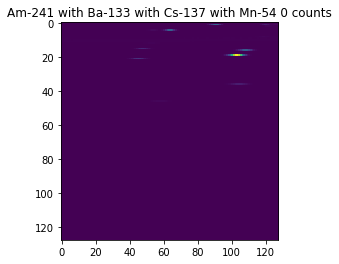

In [28]:
a, b = s[2]
c = b['predictions_counts']
b = b['predictions_nuclei']
plt.imshow(a[0].reshape((128, 128)))
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]) + " {:.0f} counts".format(np.sum(c[0])))
plt.show()

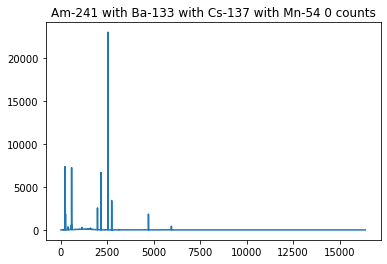

In [29]:
plt.title(" with ".join(binarizer.inverse_transform(np.array([b[0]]))[0]) + " {:.0f} counts".format(np.sum(c[0])))
plt.plot(a[0].reshape(-1))
plt.show()

In [30]:
def accuracy_score_wrapper(label, pred):
    threshold = .95
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

def my_accuracy_score(label, pred):
    metric_value = tf.compat.v1.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [40]:
K.clear_session()
import keras
vgg_model = VGG19(include_top=False,
                  weights=None,
                  input_shape=(128, 128, 1),
                  classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)

pred_nuclei = keras.layers.Dense(10, activation='sigmoid', name="predictions_nuclei")(x)

x1 = keras.layers.Flatten()(vgg_model.output)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
x1 = keras.layers.Dense(4096, activation='relu')(x1)

pred_counts = keras.layers.Dense(10, activation=None)(x1)

pred_counts = keras.layers.multiply([pred_counts, pred_nuclei], name="predictions_counts")



#se a previsão do modelo for menor que zero, a gente zera a saída, afinal de contas
#não existe atividade 0 bq :P
#pred_counts = keras.layers.Lambda(lambda x: tf.where(x < 0, tf.zeros_like(x), x),
#                                 name="predictions_counts")(pred_counts)

model = keras.models.Model(vgg_model.input, [pred_nuclei, pred_counts])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [41]:
learning_rate = 1e-4
epochs = 250
batch_size = 8
steps_per_epoch = len(X_train) // batch_size + 1
validation_steps = len(X_test) // batch_size + 1

In [42]:
opt = SGD(lr=learning_rate,
          nesterov=False,
          momentum=0.9) # keras.optimizers.RMSprop(0.001)

model.compile(optimizer=opt,
              loss={
                  'predictions_nuclei': 'binary_crossentropy',
                  'predictions_counts': 'mean_squared_error'
              },
              metrics={
                  'predictions_nuclei': [my_accuracy_score, 'accuracy'],
                  'predictions_counts': ['mean_squared_error', 'mean_absolute_error']
              }
             )

In [43]:
!nvidia-smi

Sun Apr  5 14:11:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
| 44%   55C    P8    10W / 180W |   7953MiB /  8117MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [44]:
!rm -rf ./logs_v2

In [45]:
"""

nao funciona bem com multiplas saidas...

class TensorBoardWrapper(keras.callbacks.TensorBoard):
    '''Sets the self.validation_data property for use with TensorBoard callback.'''

    def __init__(self, batch_gen, nb_steps, **kwargs):
        super(TensorBoardWrapper, self).__init__(**kwargs)
        self.batch_gen = batch_gen # The generator.
        self.nb_steps = nb_steps   # Number of times to call next() on the generator.

    def on_epoch_end(self, epoch, logs):
        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.
        # Below is an example that yields images and classification tags.
        # After it's filled in, the regular on_epoch_end method has access to the validation_data.
        imgs, tags = None, None
        for s in range(self.nb_steps):
            ib, tb = next(self.batch_gen)
            if imgs is None and tags is None:
                imgs = np.zeros(((self.nb_steps * ib.shape[0],) + ib.shape[1:]), dtype=np.float32)
                tags = np.zeros(((self.nb_steps * tb.shape[0],) + tb.shape[1:]), dtype=np.uint8)
            imgs[s * ib.shape[0]:(s + 1) * ib.shape[0]] = ib
            tags[s * tb.shape[0]:(s + 1) * tb.shape[0]] = tb
        self.validation_data = [imgs, tags, np.ones(imgs.shape[0]), 0.0]
        return super(TensorBoardWrapper, self).on_epoch_end(epoch, logs)
"""

"\n\nnao funciona bem com multiplas saidas...\n\nclass TensorBoardWrapper(keras.callbacks.TensorBoard):\n    '''Sets the self.validation_data property for use with TensorBoard callback.'''\n\n    def __init__(self, batch_gen, nb_steps, **kwargs):\n        super(TensorBoardWrapper, self).__init__(**kwargs)\n        self.batch_gen = batch_gen # The generator.\n        self.nb_steps = nb_steps   # Number of times to call next() on the generator.\n\n    def on_epoch_end(self, epoch, logs):\n        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.\n        # Below is an example that yields images and classification tags.\n        # After it's filled in, the regular on_epoch_end method has access to the validation_data.\n        imgs, tags = None, None\n        for s in range(self.nb_steps):\n            ib, tb = next(self.batch_gen)\n            if imgs is None and tags is None:\n                imgs = np.zeros(((self.nb_steps * ib.shape[0],)

In [46]:
gerador_treino = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=10)

tb = keras.callbacks.TensorBoard(
    log_dir='./logs_v2',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    #batch_gen=gerador_validacao,
    #nb_steps=validation_steps,
    update_freq='epoch')

#EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

callbacks = [es, tb]

hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=2,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)


Epoch 1/250
 - 106s - loss: 1.0331 - predictions_nuclei_loss: 0.5870 - predictions_counts_loss: 0.4461 - predictions_nuclei_my_accuracy_score: 0.0238 - predictions_nuclei_acc: 0.8249 - predictions_counts_mean_squared_error: 0.4461 - predictions_counts_mean_absolute_error: 0.3732 - val_loss: 0.9240 - val_predictions_nuclei_loss: 0.5683 - val_predictions_counts_loss: 0.3557 - val_predictions_nuclei_my_accuracy_score: 0.0318 - val_predictions_nuclei_acc: 0.8394 - val_predictions_counts_mean_squared_error: 0.3557 - val_predictions_counts_mean_absolute_error: 0.3177
Epoch 2/250
 - 106s - loss: 0.8122 - predictions_nuclei_loss: 0.5326 - predictions_counts_loss: 0.2796 - predictions_nuclei_my_accuracy_score: 0.0451 - predictions_nuclei_acc: 0.8429 - predictions_counts_mean_squared_error: 0.2796 - predictions_counts_mean_absolute_error: 0.2813 - val_loss: 0.7852 - val_predictions_nuclei_loss: 0.5245 - val_predictions_counts_loss: 0.2606 - val_predictions_nuclei_my_accuracy_score: 0.0651 - val_

Epoch 16/250
 - 106s - loss: 0.4256 - predictions_nuclei_loss: 0.3145 - predictions_counts_loss: 0.1111 - predictions_nuclei_my_accuracy_score: 0.1260 - predictions_nuclei_acc: 0.8877 - predictions_counts_mean_squared_error: 0.1111 - predictions_counts_mean_absolute_error: 0.1870 - val_loss: 0.4339 - val_predictions_nuclei_loss: 0.3227 - val_predictions_counts_loss: 0.1113 - val_predictions_nuclei_my_accuracy_score: 0.1318 - val_predictions_nuclei_acc: 0.8889 - val_predictions_counts_mean_squared_error: 0.1113 - val_predictions_counts_mean_absolute_error: 0.1785
Epoch 17/250
 - 106s - loss: 0.4110 - predictions_nuclei_loss: 0.3038 - predictions_counts_loss: 0.1072 - predictions_nuclei_my_accuracy_score: 0.1360 - predictions_nuclei_acc: 0.8907 - predictions_counts_mean_squared_error: 0.1072 - predictions_counts_mean_absolute_error: 0.1858 - val_loss: 0.4161 - val_predictions_nuclei_loss: 0.3100 - val_predictions_counts_loss: 0.1061 - val_predictions_nuclei_my_accuracy_score: 0.1508 - va

Epoch 31/250
 - 106s - loss: 0.2867 - predictions_nuclei_loss: 0.1898 - predictions_counts_loss: 0.0968 - predictions_nuclei_my_accuracy_score: 0.2707 - predictions_nuclei_acc: 0.9347 - predictions_counts_mean_squared_error: 0.0968 - predictions_counts_mean_absolute_error: 0.2127 - val_loss: 0.3058 - val_predictions_nuclei_loss: 0.2004 - val_predictions_counts_loss: 0.1054 - val_predictions_nuclei_my_accuracy_score: 0.2846 - val_predictions_nuclei_acc: 0.9322 - val_predictions_counts_mean_squared_error: 0.1054 - val_predictions_counts_mean_absolute_error: 0.2268
Epoch 32/250
 - 106s - loss: 0.2709 - predictions_nuclei_loss: 0.1825 - predictions_counts_loss: 0.0884 - predictions_nuclei_my_accuracy_score: 0.2790 - predictions_nuclei_acc: 0.9377 - predictions_counts_mean_squared_error: 0.0884 - predictions_counts_mean_absolute_error: 0.2117 - val_loss: 0.2858 - val_predictions_nuclei_loss: 0.1964 - val_predictions_counts_loss: 0.0894 - val_predictions_nuclei_my_accuracy_score: 0.2786 - va

Epoch 46/250
 - 106s - loss: 0.1752 - predictions_nuclei_loss: 0.1028 - predictions_counts_loss: 0.0724 - predictions_nuclei_my_accuracy_score: 0.4972 - predictions_nuclei_acc: 0.9680 - predictions_counts_mean_squared_error: 0.0724 - predictions_counts_mean_absolute_error: 0.2193 - val_loss: 0.2057 - val_predictions_nuclei_loss: 0.1255 - val_predictions_counts_loss: 0.0802 - val_predictions_nuclei_my_accuracy_score: 0.4890 - val_predictions_nuclei_acc: 0.9605 - val_predictions_counts_mean_squared_error: 0.0802 - val_predictions_counts_mean_absolute_error: 0.2297
Epoch 47/250
 - 106s - loss: 0.1761 - predictions_nuclei_loss: 0.1027 - predictions_counts_loss: 0.0734 - predictions_nuclei_my_accuracy_score: 0.4974 - predictions_nuclei_acc: 0.9675 - predictions_counts_mean_squared_error: 0.0734 - predictions_counts_mean_absolute_error: 0.2211 - val_loss: 0.1979 - val_predictions_nuclei_loss: 0.1221 - val_predictions_counts_loss: 0.0758 - val_predictions_nuclei_my_accuracy_score: 0.5053 - va

Epoch 61/250
 - 106s - loss: 0.1380 - predictions_nuclei_loss: 0.0700 - predictions_counts_loss: 0.0680 - predictions_nuclei_my_accuracy_score: 0.6234 - predictions_nuclei_acc: 0.9801 - predictions_counts_mean_squared_error: 0.0680 - predictions_counts_mean_absolute_error: 0.2174 - val_loss: 0.1779 - val_predictions_nuclei_loss: 0.1006 - val_predictions_counts_loss: 0.0773 - val_predictions_nuclei_my_accuracy_score: 0.6290 - val_predictions_nuclei_acc: 0.9701 - val_predictions_counts_mean_squared_error: 0.0773 - val_predictions_counts_mean_absolute_error: 0.2265
Epoch 62/250
 - 106s - loss: 0.1360 - predictions_nuclei_loss: 0.0702 - predictions_counts_loss: 0.0658 - predictions_nuclei_my_accuracy_score: 0.6289 - predictions_nuclei_acc: 0.9801 - predictions_counts_mean_squared_error: 0.0658 - predictions_counts_mean_absolute_error: 0.2176 - val_loss: 0.1768 - val_predictions_nuclei_loss: 0.0977 - val_predictions_counts_loss: 0.0791 - val_predictions_nuclei_my_accuracy_score: 0.6155 - va

Epoch 76/250
 - 106s - loss: 0.1016 - predictions_nuclei_loss: 0.0476 - predictions_counts_loss: 0.0540 - predictions_nuclei_my_accuracy_score: 0.7385 - predictions_nuclei_acc: 0.9883 - predictions_counts_mean_squared_error: 0.0540 - predictions_counts_mean_absolute_error: 0.2018 - val_loss: 0.1517 - val_predictions_nuclei_loss: 0.0843 - val_predictions_counts_loss: 0.0674 - val_predictions_nuclei_my_accuracy_score: 0.7104 - val_predictions_nuclei_acc: 0.9766 - val_predictions_counts_mean_squared_error: 0.0674 - val_predictions_counts_mean_absolute_error: 0.2150
Epoch 77/250
 - 106s - loss: 0.1015 - predictions_nuclei_loss: 0.0475 - predictions_counts_loss: 0.0540 - predictions_nuclei_my_accuracy_score: 0.7403 - predictions_nuclei_acc: 0.9879 - predictions_counts_mean_squared_error: 0.0540 - predictions_counts_mean_absolute_error: 0.2017 - val_loss: 0.1536 - val_predictions_nuclei_loss: 0.0837 - val_predictions_counts_loss: 0.0699 - val_predictions_nuclei_my_accuracy_score: 0.7152 - va

Epoch 91/250
 - 106s - loss: 0.0888 - predictions_nuclei_loss: 0.0384 - predictions_counts_loss: 0.0504 - predictions_nuclei_my_accuracy_score: 0.7907 - predictions_nuclei_acc: 0.9917 - predictions_counts_mean_squared_error: 0.0504 - predictions_counts_mean_absolute_error: 0.1914 - val_loss: 0.1445 - val_predictions_nuclei_loss: 0.0784 - val_predictions_counts_loss: 0.0661 - val_predictions_nuclei_my_accuracy_score: 0.7487 - val_predictions_nuclei_acc: 0.9793 - val_predictions_counts_mean_squared_error: 0.0661 - val_predictions_counts_mean_absolute_error: 0.2086
Epoch 92/250
 - 106s - loss: 0.0876 - predictions_nuclei_loss: 0.0374 - predictions_counts_loss: 0.0501 - predictions_nuclei_my_accuracy_score: 0.7971 - predictions_nuclei_acc: 0.9918 - predictions_counts_mean_squared_error: 0.0501 - predictions_counts_mean_absolute_error: 0.1913 - val_loss: 0.1422 - val_predictions_nuclei_loss: 0.0812 - val_predictions_counts_loss: 0.0610 - val_predictions_nuclei_my_accuracy_score: 0.7440 - va

Epoch 106/250
 - 106s - loss: 0.0748 - predictions_nuclei_loss: 0.0312 - predictions_counts_loss: 0.0437 - predictions_nuclei_my_accuracy_score: 0.8294 - predictions_nuclei_acc: 0.9941 - predictions_counts_mean_squared_error: 0.0437 - predictions_counts_mean_absolute_error: 0.1780 - val_loss: 0.1389 - val_predictions_nuclei_loss: 0.0754 - val_predictions_counts_loss: 0.0635 - val_predictions_nuclei_my_accuracy_score: 0.7735 - val_predictions_nuclei_acc: 0.9805 - val_predictions_counts_mean_squared_error: 0.0635 - val_predictions_counts_mean_absolute_error: 0.1955
Epoch 107/250
 - 106s - loss: 0.0735 - predictions_nuclei_loss: 0.0308 - predictions_counts_loss: 0.0427 - predictions_nuclei_my_accuracy_score: 0.8351 - predictions_nuclei_acc: 0.9942 - predictions_counts_mean_squared_error: 0.0427 - predictions_counts_mean_absolute_error: 0.1759 - val_loss: 0.1388 - val_predictions_nuclei_loss: 0.0757 - val_predictions_counts_loss: 0.0631 - val_predictions_nuclei_my_accuracy_score: 0.7823 - 

In [47]:
from keras.models import save_model
save_model(model, 'VGG-19-SGD-classificacao-regressao-PENELOPE-v2.hdf5')

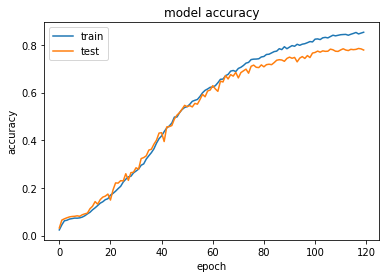

In [48]:
plt.plot(hist.history['predictions_nuclei_my_accuracy_score'])
plt.plot(hist.history['val_predictions_nuclei_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

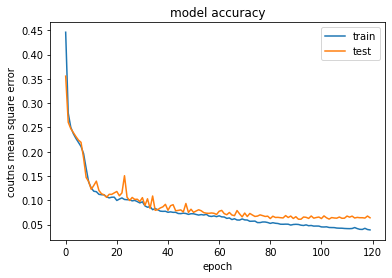

In [49]:
plt.plot(hist.history['predictions_counts_mean_squared_error'])
plt.plot(hist.history['val_predictions_counts_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('coutns mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

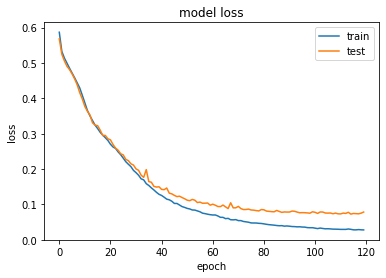

In [50]:
plt.plot(hist.history['predictions_nuclei_loss'])
plt.plot(hist.history['val_predictions_nuclei_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Validando nos espectros criados com Penelope

In [51]:
from keras.utils.vis_utils import plot_model

In [ ]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

327


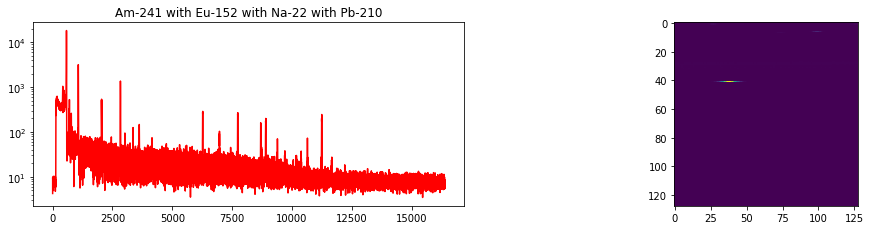

In [74]:
#idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
print(idx_)
x_, aux_ = gerador_validacao[idx_]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 3
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

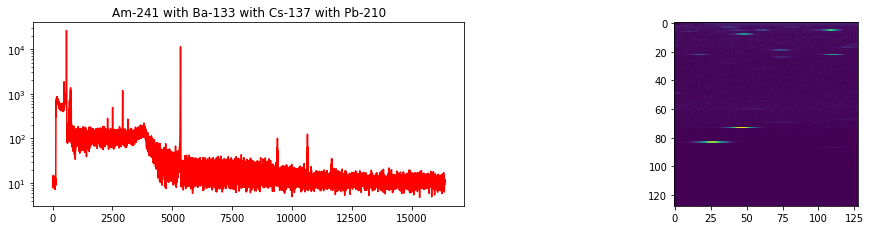

In [75]:
#idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
x_, aux_ = gerador_validacao[0]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 3
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [76]:
preds = model.predict(np.array([x_[idx].reshape((128, 128, 1))]))

In [77]:
df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': scaler.inverse_transform(y_counts[idx])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"464,558.16","454,883.78"
1,Ba-133,100.00,"26,162.54","106,707.08"
2,Cd-109,0.00,"3,413.82",0.00
3,Co-57,0.16,"16,729.17",0.00
4,Co-60,0.00,"212,589.05",0.00
5,Cs-137,100.00,"662,250.50","595,208.16"
6,Eu-152,2.14,"20,356.48",0.00
7,Mn-54,1.96,"66,154.69",0.00
8,Na-22,0.01,"213,353.42",0.00
9,Pb-210,100.00,"100,218.32","108,113.32"


In [ ]:
# Criar uma massa de dados simulando com papel ao invés de água
# Corrigir as contagens na entrada pela eficiência da similação
# Re-treinar

# Validando nos espectros experimentais

In [57]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [58]:
arquivos = ['Am-241 - BG.IEC',
            'Ba-133 - BG.IEC',
            'Cd-109 - BG.IEC',
            'Co-57 - BG.IEC',
            'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC',
            'Eu-152 - BG.IEC',
            'Mn-54 - BG.IEC',
            'Na-22 - BG.IEC',
            'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [ ]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [59]:
preds = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images['Am-241'])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,100.00,"156,141.00","141,596.00"
1,Ba-133,2.88,"9,490.93","141,596.00"
2,Cd-109,0.68,"3,274.90","141,596.00"
3,Co-57,2.06,"14,190.21","141,596.00"
4,Co-60,0.02,"209,287.31","141,596.00"
5,Cs-137,4.82,"-30,429.09","141,596.00"
6,Eu-152,1.34,"-15,473.00","141,596.00"
7,Mn-54,1.51,"60,959.54","141,596.00"
8,Na-22,2.18,"100,990.26","141,596.00"
9,Pb-210,0.04,"3,332.64","141,596.00"


In [60]:
validation_nuclei = 'Ba-133'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.06,"15,851.72","35,319.00"
1,Ba-133,100.00,"51,301.25","35,319.00"
2,Cd-109,0.69,"3,324.34","35,319.00"
3,Co-57,3.24,"14,724.16","35,319.00"
4,Co-60,0.04,"207,010.03","35,319.00"
5,Cs-137,3.70,"-5,576.63","35,319.00"
6,Eu-152,1.47,"-14,428.52","35,319.00"
7,Mn-54,1.41,"61,665.84","35,319.00"
8,Na-22,1.77,"143,846.67","35,319.00"
9,Pb-210,0.32,"3,277.91","35,319.00"


In [61]:
validation_nuclei = 'Cd-109'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"15,892.65","7,195.00"
1,Ba-133,2.67,"-3,891.03","7,195.00"
2,Cd-109,99.94,"19,634.31","7,195.00"
3,Co-57,4.09,"5,514.90","7,195.00"
4,Co-60,1.54,"20,408.62","7,195.00"
5,Cs-137,2.20,-690.95,"7,195.00"
6,Eu-152,1.43,"-33,518.87","7,195.00"
7,Mn-54,1.89,"62,404.35","7,195.00"
8,Na-22,2.04,"116,090.34","7,195.00"
9,Pb-210,0.00,"3,338.74","7,195.00"


In [62]:
validation_nuclei = 'Co-57'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"15,892.53","7,323.00"
1,Ba-133,3.75,"-5,203.22","7,323.00"
2,Cd-109,0.36,"3,366.14","7,323.00"
3,Co-57,99.68,"12,855.37","7,323.00"
4,Co-60,0.18,"185,346.89","7,323.00"
5,Cs-137,3.05,"-9,655.38","7,323.00"
6,Eu-152,1.16,"-5,789.62","7,323.00"
7,Mn-54,3.79,"52,059.04","7,323.00"
8,Na-22,1.67,"139,226.66","7,323.00"
9,Pb-210,0.00,"3,338.83","7,323.00"


In [63]:
validation_nuclei = 'Co-60'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"15,892.61","155,643.00"
1,Ba-133,2.02,"19,618.46","155,643.00"
2,Cd-109,0.23,"3,382.47","155,643.00"
3,Co-57,0.33,"16,361.19","155,643.00"
4,Co-60,100.00,"156,416.22","155,643.00"
5,Cs-137,3.25,"-4,737.44","155,643.00"
6,Eu-152,4.42,"-40,493.85","155,643.00"
7,Mn-54,0.54,"71,374.52","155,643.00"
8,Na-22,2.46,"166,538.56","155,643.00"
9,Pb-210,0.00,"3,338.47","155,643.00"


In [64]:
validation_nuclei = 'Cs-137'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.03,"15,880.37","188,461.00"
1,Ba-133,4.43,"16,173.28","188,461.00"
2,Cd-109,0.10,"3,391.07","188,461.00"
3,Co-57,0.98,"15,796.29","188,461.00"
4,Co-60,0.00,"212,290.59","188,461.00"
5,Cs-137,100.00,"222,605.23","188,461.00"
6,Eu-152,1.95,"-7,642.27","188,461.00"
7,Mn-54,2.80,"63,020.91","188,461.00"
8,Na-22,0.56,"198,931.16","188,461.00"
9,Pb-210,0.12,"3,315.10","188,461.00"


In [65]:
validation_nuclei = 'Eu-152'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.38,"15,784.01","94,419.00"
1,Ba-133,1.82,"36,447.51","94,419.00"
2,Cd-109,0.06,"3,403.13","94,419.00"
3,Co-57,1.39,"15,896.01","94,419.00"
4,Co-60,0.00,"212,364.02","94,419.00"
5,Cs-137,2.23,"27,721.42","94,419.00"
6,Eu-152,99.93,"127,647.67","94,419.00"
7,Mn-54,0.86,"71,454.24","94,419.00"
8,Na-22,0.56,"210,789.69","94,419.00"
9,Pb-210,0.18,"3,317.98","94,419.00"


In [66]:
validation_nuclei = 'Mn-54'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"15,892.65","7,159.00"
1,Ba-133,2.68,"-15,286.92","7,159.00"
2,Cd-109,0.70,"3,210.11","7,159.00"
3,Co-57,5.29,49.42,"7,159.00"
4,Co-60,0.12,"193,122.08","7,159.00"
5,Cs-137,2.23,-17.98,"7,159.00"
6,Eu-152,1.30,"-41,320.71","7,159.00"
7,Mn-54,89.45,"-84,025.52","7,159.00"
8,Na-22,2.67,"81,076.30","7,159.00"
9,Pb-210,0.00,"3,338.81","7,159.00"


In [67]:
validation_nuclei = 'Na-22'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,"15,892.65","7,965.00"
1,Ba-133,3.03,"-13,706.59","7,965.00"
2,Cd-109,0.24,"3,344.76","7,965.00"
3,Co-57,1.47,"11,113.53","7,965.00"
4,Co-60,0.43,"150,356.47","7,965.00"
5,Cs-137,3.13,"-6,002.02","7,965.00"
6,Eu-152,1.51,"-35,733.10","7,965.00"
7,Mn-54,1.17,"68,294.89","7,965.00"
8,Na-22,99.98,"-309,047.41","7,965.00"
9,Pb-210,0.00,"3,338.78","7,965.00"


In [68]:
validation_nuclei = 'Pb-210'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,4.20,"13,052.41","19,650.00"
1,Ba-133,2.63,"11,709.32","19,650.00"
2,Cd-109,1.89,"3,202.34","19,650.00"
3,Co-57,0.47,"16,374.04","19,650.00"
4,Co-60,0.19,"184,933.80","19,650.00"
5,Cs-137,3.24,"-10,640.53","19,650.00"
6,Eu-152,1.34,"-19,157.15","19,650.00"
7,Mn-54,2.43,"46,291.78","19,650.00"
8,Na-22,3.59,"-10,285.43","19,650.00"
9,Pb-210,100.00,"34,802.18","19,650.00"


## Fonte triplice de calibração

In [69]:
dados = []

with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df_triplice = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

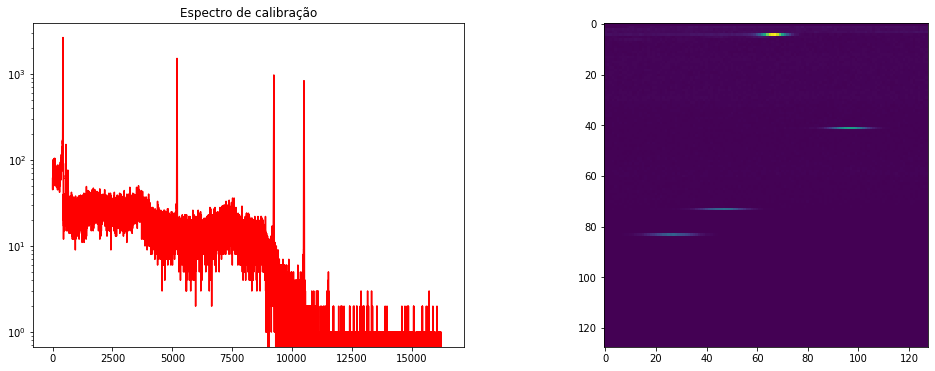

In [70]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro de calibração")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [72]:
shift_ = 0
dados = df_triplice.counts.shift(shift_).fillna(0).values

preds = model.predict(np.array([dados.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'real_counts': np.sum(dados)})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,50.40,"24,013.48","276,428.00"
1,Ba-133,1.17,"38,102.12","276,428.00"
2,Cd-109,0.19,"3,440.69","276,428.00"
3,Co-57,1.48,"15,939.20","276,428.00"
4,Co-60,100.00,"72,626.05","276,428.00"
5,Cs-137,100.00,"58,826.16","276,428.00"
6,Eu-152,7.17,"-19,990.90","276,428.00"
7,Mn-54,0.71,"70,544.93","276,428.00"
8,Na-22,0.40,"209,368.78","276,428.00"
9,Pb-210,6.22,"2,826.83","276,428.00"


In [73]:
24013.48 + 58826.16 + 72626.05

155465.69